# Heart Failure 

In [2]:
# 필요한 라이브러리 import
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

### 데이터 불러오기

In [ ]:
# before R preprocessing (raw data)
df = pd.read_csv('heart_failure_clinical_records_dataset.csv')
# after R preprocessing
clean_df = pd.read_csv('heart_failure_clean.csv')

# 데이터 확인
print(df.head())
print(clean_df.head())

,age,anaemia,creatinine_phosphokinase,diabetes,ejection_fraction,high_blood_pressure,platelets,serum_creatinine,serum_sodium,sex,smoking,time,DEATH_EVENT,High_blood_pressure,ct_gr
0,75.0,0,582,0,20,1,265000.00,1.9,130,1,0,4,1,1,1
1,55.0,0,7861,0,38,0,263358.03,1.1,136,1,0,6,1,0,0
2,65.0,0,146,0,20,0,162000.00,1.3,129,1,1,7,1,0,0
3,50.0,1,111,0,20,0,210000.00,1.9,137,1,0,7,1,0,1
4,65.0,1,160,1,20,0,327000.00,2.7,116,0,0,8,1,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
294,62.0,0,61,1,38,1,155000.00,1.1,143,1,1,270,0,1,0
295,55.0,0,1820,0,38,0,270000.00,1.2,139,0,0,271,0,0,0
296,45.0,0,2060,1,60,0,742000.00,0.8,138,0,0,278,0,0,0
297,45.0,0,2413,0,38,0,140000.00,1.4,140,1,1,280,0,0,0


### EDA(탐색적 데이터 분석)

In [ ]:
# 한글 깨짐 방지
plt.rcParams['font.family'] ='Malgun Gothic'
plt.rcParams['axes.unicode_minus'] =False

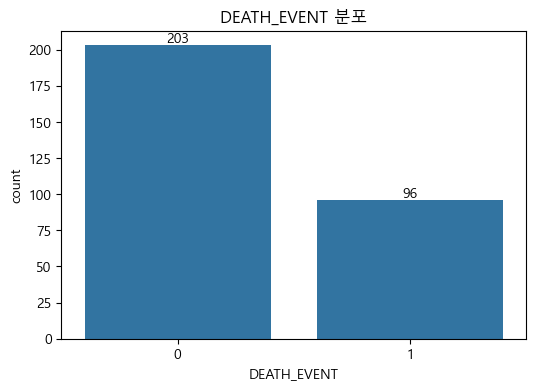

In [ ]:
# 클래스 불균형 확인
plt.figure(figsize=(6,4))
ax = sns.countplot(x= df["DEATH_EVENT"], data=df)
ax.bar_label(ax.containers[0])
plt.title('DEATH_EVENT 분포')
plt.show()

203:96으로 0 클래스가 67.9%로 아주 약한 불균형

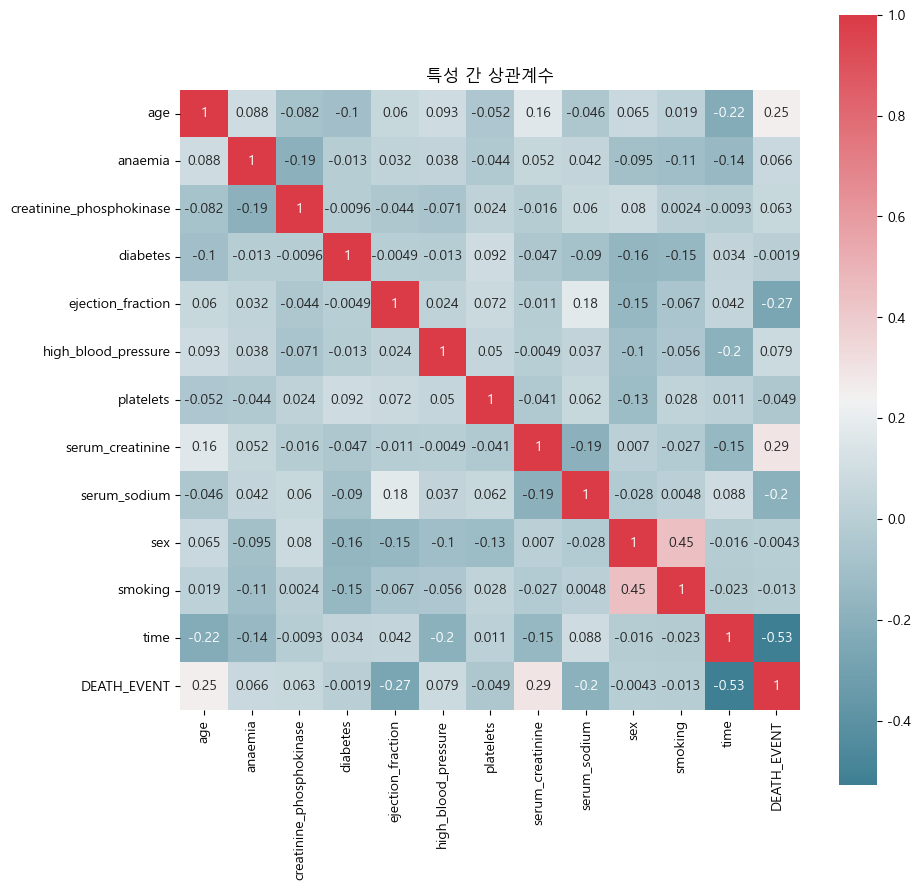

In [11]:
 # 상관계수 행렬(heatmap)
corrmat = df.corr()
cmap = sns.diverging_palette(220, 10, as_cmap=True)
plt.subplots(figsize=(10,10))
sns.heatmap(corrmat, cmap=cmap, annot=True, square=True)
plt.title('특성 간 상관계수')
plt.show()

age, ejection_fraction,serum_creatinine, serum_sodium, time가  
DEATH_EVENT와 0.2(약한 상관)이상


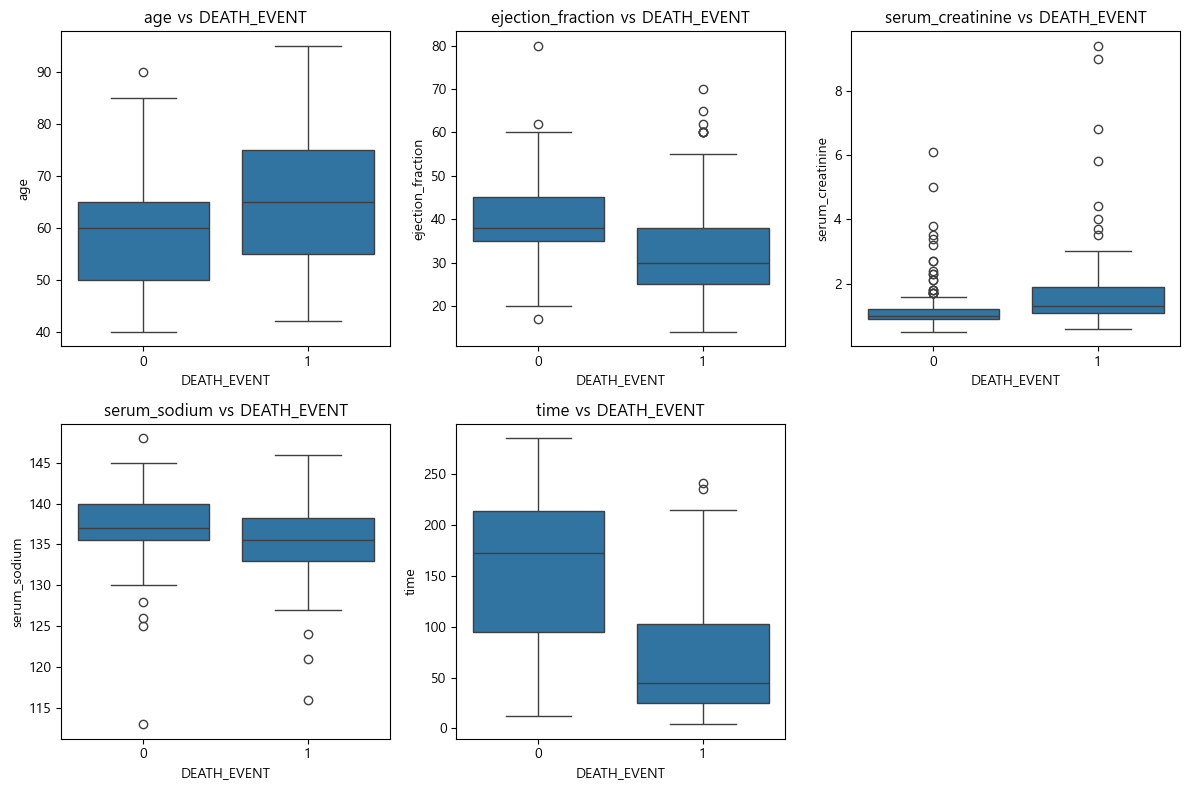

In [12]:
# 주요 수치형 변수의 이상치 확인 (Boxplot)
plt.figure(figsize=(12, 8))

features = ['age', 'ejection_fraction', 'serum_creatinine', 'serum_sodium', 'time']
for idx, feature in enumerate(features, 1):
    plt.subplot(2, 3, idx)
    sns.boxplot(x='DEATH_EVENT', y=feature, data=df)
    plt.title(f'{feature} vs DEATH_EVENT')

plt.tight_layout()
plt.show()

In [ ]:
# 이상치 개수 확인 (IQR 기준)
def find_outliers_iqr(data_column):
    quartile_1, quartile_3 = np.percentile(data_column, [25, 75])
    iqr = quartile_3 - quartile_1
    lower_bound = quartile_1 - 1.5 * iqr
    upper_bound = quartile_3 + 1.5 * iqr
    outliers = np.where((data_column < lower_bound) | (data_column > upper_bound))[0]
    return outliers
def count_outliers_iqr(data):
    outlier_count = 0
    for column in data.columns:
        outliers = find_outliers_iqr(data[column])
        outlier_count += len(outliers)
        print(f"IQR 이상치 ({column}): {len(outliers)} 개")
    print(f"총 이상치 개수: {outlier_count} 개")
count_outliers_iqr(clean_df)

In [ ]:
#변수 선택
use_df = clean_df[['age','ejection_fraction','serum_sodium','time','ct_gr','DEATH_EVENT']]
use_df.info()

### 학습/테스트 데이터 분리

In [ ]:
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
from sklearn.decomposition import PCA

In [ ]:
X = use_df.drop(["DEATH_EVENT"],axis=1)
y = use_df['DEATH_EVENT']
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.3,random_state=42)

### SMOTE

In [ ]:
# 1. SMOTE 적용 (여기까지는 숫자 데이터만 있어야 함)
smote = SMOTE(random_state=42)
X_train = X_train.select_dtypes(include=["number"])
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

X_train["category"] = "NO_SMOTE"
X_train_smote["category"] = "SMOTE"

final_X = pd.concat([X_train, X_train_smote], axis=0).copy()

final_cat = final_X["category"]
final_X.drop(columns="category",inplace=True)
pca = PCA(n_components=2)
final_X = pd.DataFrame(pca.fit_transform(final_X))
final_X["category"] = list(final_cat)
final_X = final_X.loc[(final_X[0]<=200000) & (final_X[1]<=2000),:].copy()
sns.relplot(data=final_X,x=0,y=1,hue="category",alpha=0.6,s=100,height=6,aspect=1.5)
plt.title("Synthetic Examples Generated Using SMOTE")


In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.metrics import classification_report, confusion_matrix

In [ ]:
selected_features = ['age', 'ejection_fraction', 'serum_sodium', 'time', 'ct_gr']
 
X_new = clean_df[selected_features].copy()
X_train, X_test, y_train, y_test = train_test_split(X_new, y, test_size=0.3, random_state=42)
 
smote = SMOTE(random_state=42) 
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)
 
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

### Random Forest

In [ ]:
model_rf = RandomForestClassifier(random_state=42)
 
gscv_rf = GridSearchCV(estimator=model_rf,param_grid={
    "n_estimators":[100,1000],
    "criterion":["gini","entropy"],
    "max_depth":[3,5],
    "min_samples_split":[8,10],
    "min_samples_leaf":[10,20],
 },cv=cv,n_jobs=-1,scoring="accuracy")
 
gscv_rf.fit(X_train_smote, y_train_smote)
 
MODEL_RF = gscv_rf.best_estimator_
MODEL_RF.score(X_train_smote,y_train_smote)

In [ ]:
MODEL_RF

In [ ]:
train_pred_rf = MODEL_RF.predict(X_train_smote)
print(classification_report(y_train_smote,train_pred_rf))

### Dicision Tree

In [ ]:
 from sklearn.tree import DecisionTreeClassifier

In [ ]:
model_dt= DecisionTreeClassifier(random_state=42)
 
gscv_dt = GridSearchCV(estimator=model_dt, param_grid={
    "criterion": ["gini", "entropy"],
    "max_depth": [3, 5, 10],
    "min_samples_split": [80,100],
    "min_samples_leaf": [20, 30],
 }, cv=cv, n_jobs=-1, scoring="accuracy")
 
gscv_dt.fit(X_train_smote, y_train_smote)
 
MODEL_DT = gscv_dt.best_estimator_
MODEL_DT.score(X_train_smote, y_train_smote)

In [ ]:
MODEL_DT

In [ ]:
train_pred_dt = MODEL_DT.predict(X_train_smote)
print(classification_report(y_train_smote,train_pred_dt))

### SVM

In [ ]:
from sklearn.svm import SVC

In [ ]:
model_svm = SVC(probability=True,random_state=42)
 
gscv_svm = GridSearchCV(estimator=model_svm, param_grid={
    'C': [1, 10],
    'kernel': ['linear', 'rbf'],
    'gamma': ['scale', 'auto']
 }, cv=cv, n_jobs=-1, scoring="f1_weighted")
 
gscv_svm.fit(X_train_smote, y_train_smote)
 
MODEL_SVM = gscv_svm.best_estimator_
MODEL_SVM.score(X_train_smote, y_train_smote)


In [ ]:
MODEL_SVM

In [ ]:
train_pred_svm = MODEL_SVM.predict(X_train_smote)
print(classification_report(y_train_smote,train_pred_svm))

### LogistiRegreesion

In [ ]:
from sklearn.linear_model import LogisticRegression

In [ ]:
model_logreg = LogisticRegression(random_state=42)
 
gscv_logreg = GridSearchCV(estimator=model_logreg, param_grid={
    'C': [0.1, 1, 10, 100],
    'penalty': ['l2'],
 }, cv=cv, n_jobs=-1, scoring="accuracy")
 
gscv_logreg.fit(X_train_smote, y_train_smote)
 
MODEL_LOGREG = gscv_logreg.best_estimator_
MODEL_LOGREG.score(X_train_smote, y_train_smote)

In [ ]:
MODEL_LOGREG

In [ ]:
train_pred_lg = MODEL_LOGREG.predict(X_train_smote)
print(classification_report(y_train_smote,train_pred_lg))

### LGBM

In [ ]:
from lightgbm import LGBMClassifier